# Praca Domowa 5

Autor: Paulina Przybyłek

## Wczytanie danych i odpowiednich pakietów

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')
np.random.seed(123)

Zadanie polega na przetestowaniu minimum 2 metod klasteryzujących. Następnie należy wybrać optymalną liczbę klastrów. Dane wykorzystywane do zadania wczytujemy z pliku `clustering.csv`, które są przedstawione w wymiarze $\mathbb{R}^2$.

In [2]:
data = pd.read_csv('../../clustering.csv', header = None)

In [3]:
data.head()

,0,1
0,41.788907,52.220182
1,-96.586516,90.957033
2,-54.143591,-99.153377
3,19.929231,-45.859779
4,-82.941076,84.099186


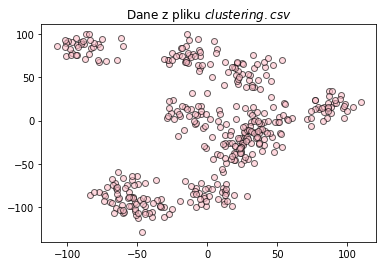

In [4]:
plt.scatter(data.loc[:,0], data.loc[:,1],alpha=0.6, edgecolor = 'black', color = 'pink')
plt.title("Dane z pliku $clustering.csv$")
plt.show()

Na powyższym wykresie możemy zaobserwować nasze dane. Nie są one jasno oddzielone od siebie, szczególnie na środku wykresu pojawia się większe skupisko, które może być podzielone na kilka klastrów. Krótko mówiąc, na pierwszy rzut oka nie możemy przewidzieć ile może ich być (5 a może 8 czy jeszcze więcej? przekonamy się za chwilę).

## Metody klasteryzujące

Wykorzystamy dwie metody: kombinatoryczną - *k-medoidów* oraz hierarhiczną - *aglomeracyjna*. Wybór odpowiednich klastrów zostanie dokonany na podstawie:
 - dla k-medoidów:
     - indeksu Daviesa–Bouldina
     - metody Silhouette
 - dla metody aglomeracyjnej:
     - indeksu Calińskiego-Harabasza
     - oraz dendrogramu
     
Postaramy się stosować domyślne implementacje metod. Metody i metryki opisane na zajęciach nie są tutaj ponownie opisywane. Nowa metoda k-medoidów (inaczej zwana PAM) działa podobnie jak metoda k-średnich, dlatego 'porównamy' je ze sobą. Dokładny opis metody można znaleźć np. na [Wikipedii](https://en.wikipedia.org/wiki/K-medoids).

#### Pomocnicze funkcje:

**Informacja**: Wykorzystamy funkcję `count_clustering_scores` napisaną w trakcie laboratorium.

In [5]:
def plot_model_clusters(X, model, title, n_clusters):
    """
    Funckja przyjmuje dane X punktów, nazwę modelu, tytuł wykresu i liczbę klastrów.
    Zwraca wykres dla danej metody podziału na odpowiednią ilość skupisk.
    Dodatkowo nanosi punkty cetrum tych skupisk.
    """    
    model = model(n_clusters=n_clusters, random_state=0).fit(X)
    y_model = model.predict(X)
    plt.scatter(X.loc[:, 0], X.loc[:, 1], c=y_model, cmap='plasma')

    centers = model.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s = 200, alpha=0.75)
    plt.title(title)
    plt.show()

In [6]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    """
    Dla podanych danych, modelu i zakresu klastrów zwraca wektor wyników podanej metryki.
    """
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

In [7]:
def plot_cluster_metrics(cluster_num_seq, score_vec, y_title_score, title):
    """
    Rysuje wykres metryki - podajemy wektor klastrów i wektor miar im odpowiadających oraz tytuł osi Y.
    """
    plt.plot(cluster_num_seq, score_vec, 'bx-')
    plt.xlabel('Liczba klastrów')
    plt.ylabel(y_title_score)
    plt.title(title)
    plt.show()

### Metoda K-medoidów

Metoda ta nie jest dostępna w podstawowym pakiecie sklearn, jednak jest w jego rozszerzeniu sklearn_extra. Zaczniemy od narysowania podziału dla 5, który na oko wydał mi się najmniejszym sensownym podziałem.

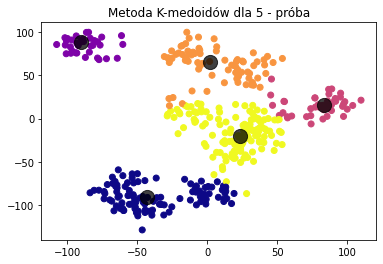

In [8]:
plot_model_clusters(data, KMedoids, 'Metoda K-medoidów dla 5 - próba', 5)

Powyżej widzimy wykres podziału na klastry przy użyciu metody K-medoidów. Wybraliśmy 5 klastrów, podział nie wygląda źle, jednak lepiej zastosować jedną z metryk wybierających optymalną ilość klastrów, żeby wybrać dobrze a nie zgadywać.

Do wyboru optymalnej ilości skupisk wykorzystamy **Indeks Daviesa–Bouldina**. Został opisany na zajęciach, dlatego nie będziemy tłumaczyć ponownie. Okazuje się, że istnieje taka wbudowana metryka w pakiecie sklearn. Na zajęciach przedstawiliśmy różne sposoby obliczania tego indeksu. Wykorzystywana metoda w zadaniu jest zdefiniowana następująco: *wynik jest definiowany jako średnia miara podobieństwa każdego skupienia z jego najbardziej podobnym skupieniem, gdzie podobieństwo jest stosunkiem odległości w obrębie skupienia do odległości między skupieniami*.

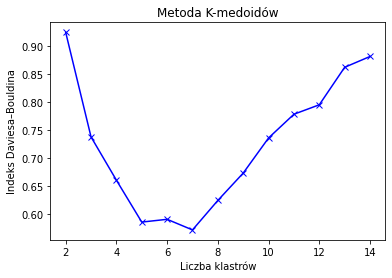

In [9]:
cluster_num_seq = range(2, 15)
davies_bouldin_vec = count_clustering_scores(data, cluster_num_seq, KMedoids, davies_bouldin_score)
plot_cluster_metrics(cluster_num_seq, davies_bouldin_vec, 'Indeks Daviesa–Bouldina', 'Metoda K-medoidów')

Indeks Daviesa–Bouldina zwraca wartości liczbowe, gdzie najlepszym wynikiem jest 0. Oznacza to, że im bliższy zera wynik tym ta liczba klastrów jest bardziej optymalna.

W naszym przypadku, na powyższym wykresie, najlepiej wypadł podział na 7 skupisk. Co ciekawe nasz wybór 5 skupisk jest drugim najlepszym wynikiem, więc zgadliśmy całkiem dobrze.

Teraz "narysujmy" nasz najbardziej optymalny wybór przy wykorzystywanej metodzie K-medoidów.

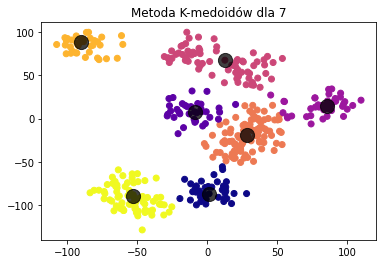

In [10]:
plot_model_clusters(data, KMedoids, 'Metoda K-medoidów dla 7', 7)

Sprawdźmy zastosowanie drugiej metryki - **metody Silhouette**. W jej przypadku chcemy wybrać liczbę klastrów, która osiąga najwyższy wynik. Czy okaże się, że liczba klastrów będzie taka sama? 

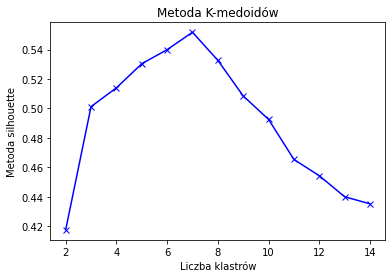

In [11]:
cluster_num_seq = range(2, 15)
silhouette_vec = count_clustering_scores(data, cluster_num_seq, KMedoids, silhouette_score)
plot_cluster_metrics(cluster_num_seq, silhouette_vec, 'Metoda silhouette', 'Metoda K-medoidów')

Jak widzimy, metryka nie zmieniła wyniku dla tej metody. Dalej jest to 7 skupisk.

Było to do przewidzenia - wykorzystywane metryki uznawane są za podobne. Natomiast metoda tworzenia skupisk się nie zmienia.

### Metoda K-średnich - bonus

Z ciekawości zobaczymy jak wyznaczy klastry metoda K-średnich przy wykorzystaniu tych samych metryk. Stosowaliśmy ją na zajęciach, dlatego nie została napisana jako druga metoda do tego zadania a jedynie jako bonus.

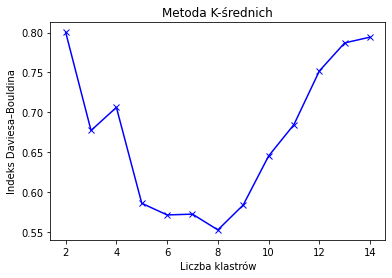

In [12]:
cluster_num_seq = range(2, 15)
davies_bouldin_vec = count_clustering_scores(data, cluster_num_seq, KMeans, davies_bouldin_score)
plot_cluster_metrics(cluster_num_seq, davies_bouldin_vec, 'Indeks Daviesa–Bouldina', 'Metoda K-średnich')

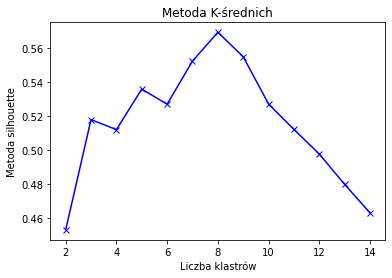

In [13]:
cluster_num_seq = range(2, 15)
silhouette_vec = count_clustering_scores(data, cluster_num_seq, KMeans, silhouette_score)
plot_cluster_metrics(cluster_num_seq, silhouette_vec, 'Metoda silhouette', 'Metoda K-średnich')

Oba wykresy wskazują iż jest to 8, czyli ta metryka wskazała inny optymalny podział. Zobaczmy go.

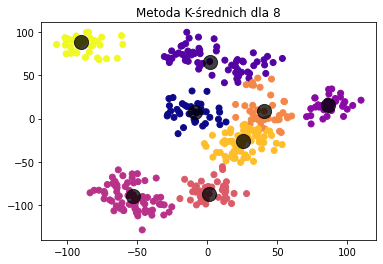

In [14]:
plot_model_clusters(data, KMedoids, 'Metoda K-średnich dla 8', 8)

### Metoda aglomeracyjna

Stosowaliśmy ją na zajęciach, należy do metod hierarchicznych, czyli innych niż te wykorzystane powyżej, dlatego warto ją przetestować.

Do wybrania odpowiedniej liczby klastrów wykorzystamy kolejną podobną do poprzednich metrykę - **indeks Calińskiego-Harabasza**. Jest również znany jako kryterium współczynnika wariancji. Wynik jest zdefiniowany jako stosunek między dyspersją wewnątrz klastra i dyspersją między klastrami.



In [15]:
# funkcja pomocnicza podobna do porzedniej, nie rysuje centrum skupisk
def plot_agglomerative_clusters(X, n_clusters):
    """
    Funkcja rysuje wykres dla wybranej liczby klastrów podziału dokonanego przez metodę aglomeracyją.
    """
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    y_agglomerative = agglomerative.fit_predict(X)
    plt.scatter(X.loc[:, 0], X.loc[:, 1], c=y_agglomerative, cmap='plasma')
    plt.title('Metoda aglomeratywna dla %.0f klastrów' % n_clusters)
    plt.show()

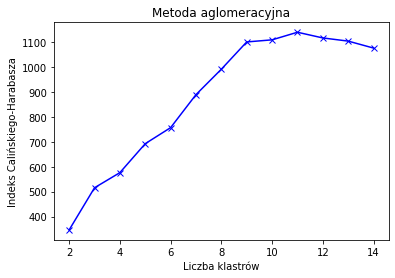

In [16]:
cluster_num_seq = range(2, 15)
calinski_harabasz_vec = count_clustering_scores(data, cluster_num_seq, AgglomerativeClustering, calinski_harabasz_score)
plot_cluster_metrics(cluster_num_seq, calinski_harabasz_vec, 'Indeks Calińskiego-Harabasza', 'Metoda aglomeracyjna')

Chcemy zmaksymalizować indeks - osiągamy to dla 11 klastrów. Uznajmy to za nasz optymalny podział i zobaczmy jak się maluje na wykresie.

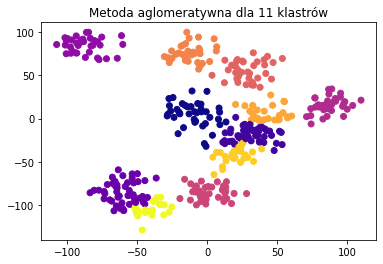

In [17]:
plot_agglomerative_clusters(data, 11)

Do tej pory stosowaliśmy podziały wybrane przez metryki, z których łatwo odczytać można było optymalną liczbę. 

Przyjrzyjmy się jeszcze jak wygląda cała hierarchia klastrów. Wykorzystamy dendrogram do wyboru wedle nas optymalnego podziału. Stosujemy ten sam model - linkage = 'ward', aby porównać z poprzednimi wynikami.

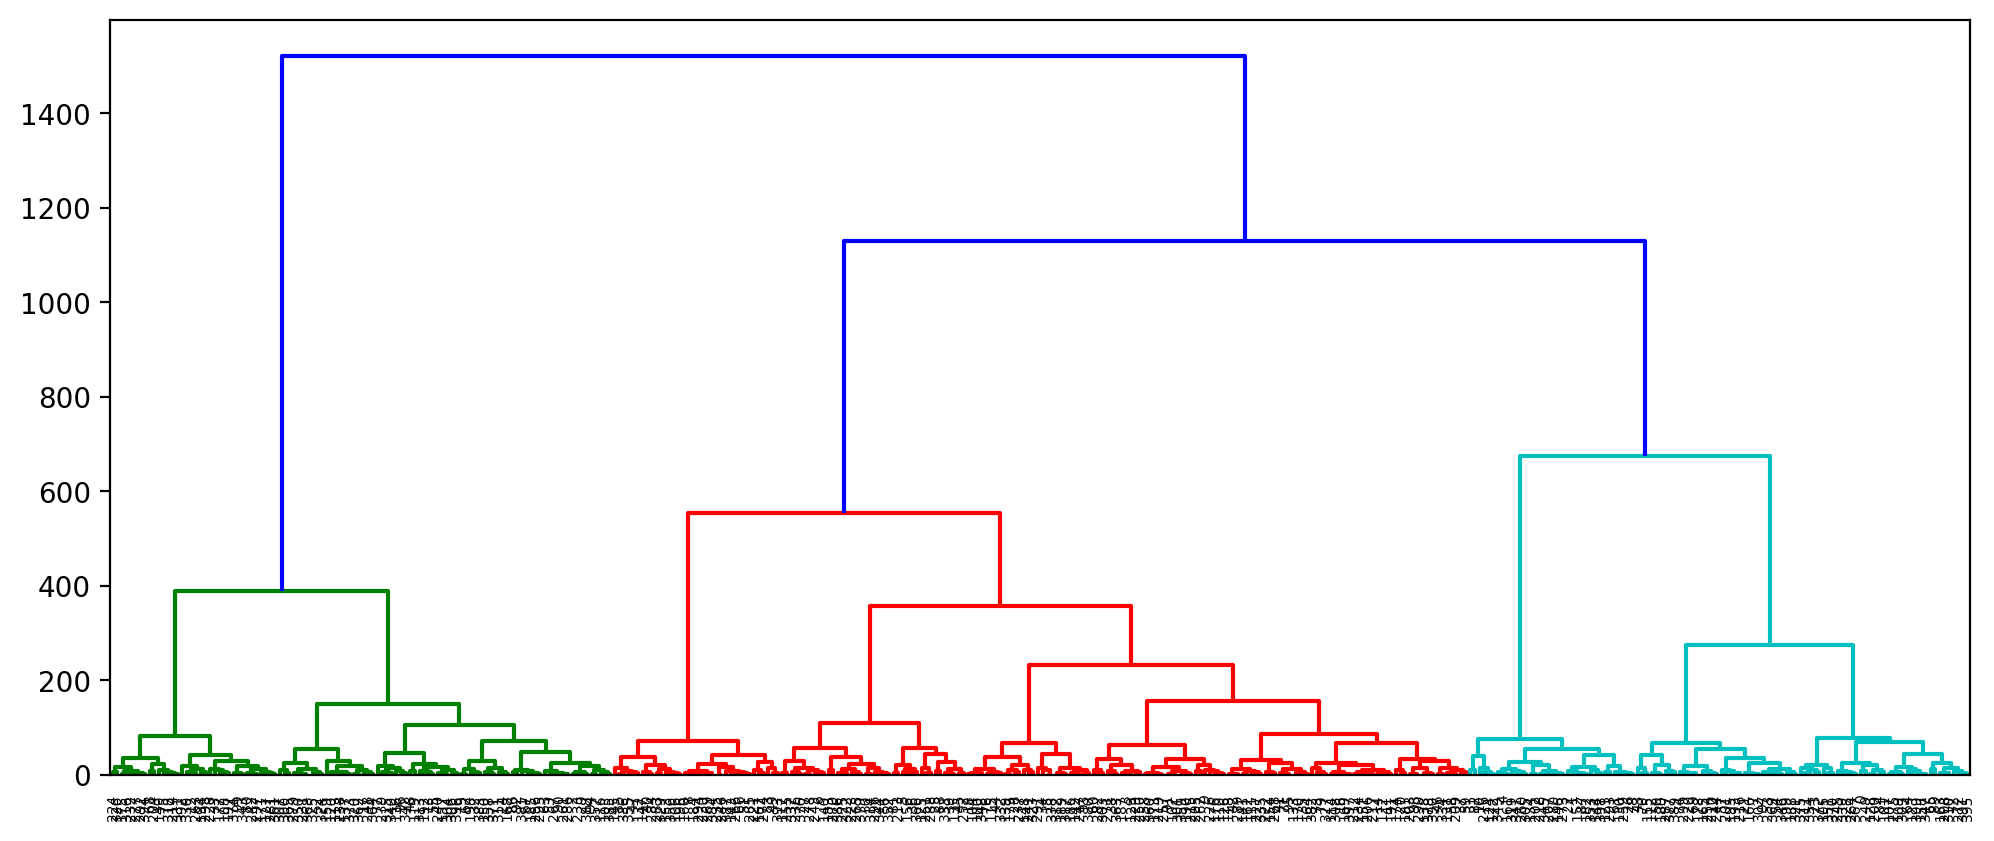

In [18]:
Z = hierarchy.linkage(data, method='ward')
plt.figure(figsize=(12, 5), dpi= 200)
hierarchy.dendrogram(Z)
plt.show()

Dla dużej liczby punktów w zbiorze nie wygląda to najlepiej. Jednak nie utrudnia to odczytu dla kilku pierwszych podziałów. Jak dla mnie podział na 9-11 klastrów jest odpowiedni - tam są jeszcze widełki niekoniecznie podzielone na wiele różnych klastrów i uważam to za wystarczające. Porównując moje wybory na oko z wynikami metryki (indeksu Calińskiego-Harabasza) to nawet się to zgadza, że ten podział jest w miarę odpowiedni.

Na oko 9-11 jest odpowiedni, dlatego wybierzmy jakiś i go narysujmy. Utnijmy nasz dendrogram linią poziomą na pewnym poziomie i policzmy ile klastrów wybraliśmy. Weżmy y=150 oraz y=200, gdyż na tej wysokości będzie wybrana przeze mnie liczba skupisk. Oznacza to, że klastry nie są od siebie bardziej oddalone niż o 150/200.

Krótkie wyjasnienie zaznaczonych linii na poniższym dendrogramie:
- kolor różowy - y=200
- kolor czarny - y=150

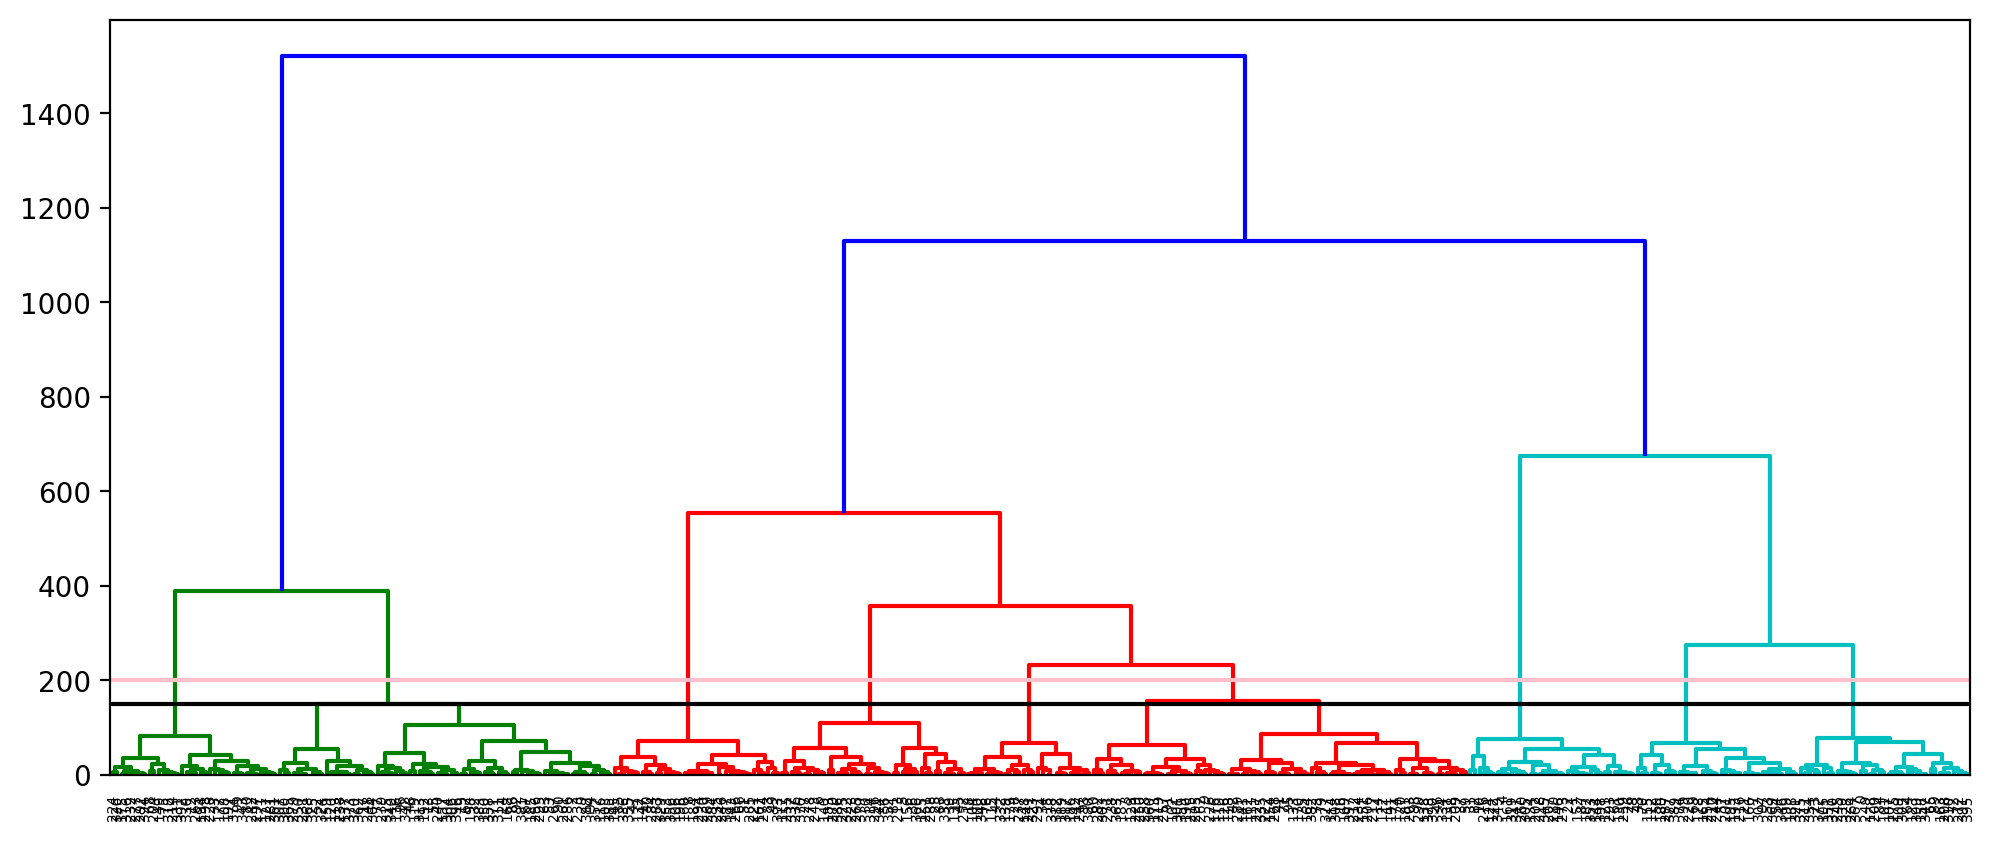

In [19]:
plt.figure(figsize=(12, 5), dpi= 200)
hierarchy.dendrogram(Z)
plt.axhline(150, color='black', linestyle = '-')
plt.axhline(200, color='pink', linestyle = '-')
plt.xticks(labels=None) #punktów jest za dużo aby to było czytelne więc usuwamy je
plt.show()

Dla y=150 mamy 11 skupisk, czyli tyle samo co wybrała metryka zastosowana wcześniej. Natomiast dla y=200 mamy 9 skupisk i wydaje się to całkiem dobrym podziałem. Zobaczmy jak podzieli dane:

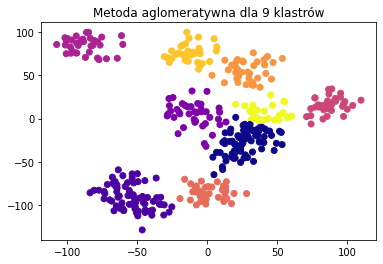

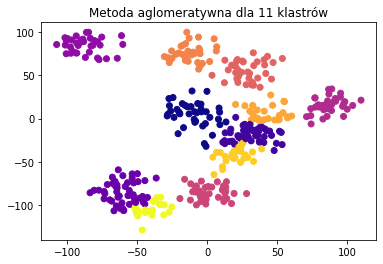

In [20]:
plot_agglomerative_clusters(data, 9)
plot_agglomerative_clusters(data, 11)

Znacząca różnica? Podzielono środkowe skupisko na dwa i to najbardziej wysunięte w lewym dolnym rogu też. Prawdopodobnie przy zwiększaniu liczby klastrów to właśnie one będą dzielić się na wiele małych skupisk, chociaż to tylko domysły, ważna jest odległość między punktami i na oko trudno ocenić jak to będzie dzielone. Jednak z ciekawości zobaczmy jak wygląda podział na większą liczbę klastrów, np. 20.

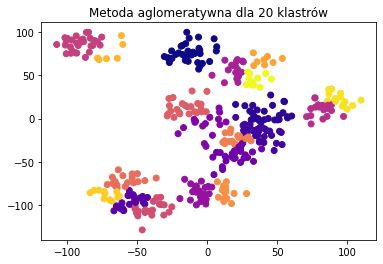

In [21]:
plot_agglomerative_clusters(data, 20)

## Podsumowanie

Osobiście podział na 8 i 9 klastrów podobał mi się najbardziej. Podsumujmy to co zrobiliśmy:
- k-medoidów - optymalne 7 klastrów
- k-średnich - optymalne 8 klastrów
- metoda aglomeracyjna - optymalne 11 klastrów (chociaż wybrane poprzez subiektywne przyglądanie się dendrogramowi 9 skupisk też wygląda dobrze)

Wykorzystywane metryki są podobne do siebie i zauważyliśmy, że wykorzystanie dwóch z nich na metodach kombinatorycznych wybrało wciąż te same klastry za najlepsze. Chociaż już drugi wybór się różnił (w jednym 5 a w drugim 6 klastrów).

Każda z metod w inny sposób wybiera podział, dlatego w zależności od tego jakie mamy dane i co chcemy uzyskać powinniśmy wybrać dla siebie odpowiednią metodę albo przetestować kilka, gdyż wyniki mogą się całkowicie różnić.

Zobatrzmy też, jak różne metody podzielą zbiór mając taką samą liczbę klastrów. Wybierzmy 8.

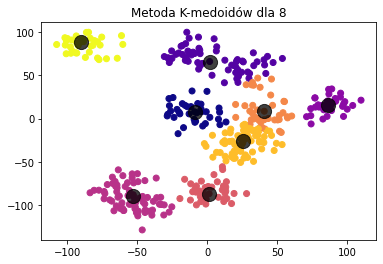

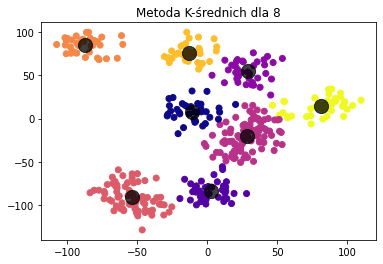

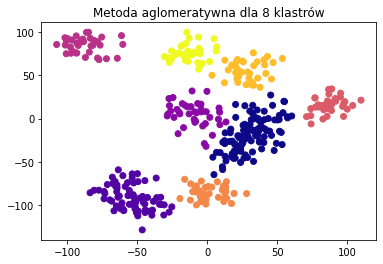

In [22]:
plot_model_clusters(data, KMedoids, 'Metoda K-medoidów dla 8', 8)
plot_model_clusters(data, KMeans, 'Metoda K-średnich dla 8', 8)
plot_agglomerative_clusters(data, 8)

Można zauważyć znaczące różnice przy podziale, dlatego ważne jest zapoznanie się ze sposobem oblicznia podziałów przez metody i wybór najlepszych dla tego co nas interesuje.